Казакова А.С.
Идея для решения данного тестового задания взята из лекции К.В. Воронцова по рекомендательным системам (http://www.machinelearning.ru/wiki/images/archive/9/95/20140413184117%21Voron-ML-CF.pdf а также ютуб). Как решение рассматривается корреляционные модели (Memory-Based Collaborative Filtering)

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

In [2]:
# Считывание данных
artist_data = pd.read_csv('/content/lastfm_artist_list.csv', index_col =0)
artist_data.head()

,artist_name
artist_id,
1,__Max__
2,_Algol_
3,-123 Min.
4,-Oz-
5,-T De Sangre


In [3]:
# Посмотрим на данные (их тип и количество nan)
artist_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17493 entries, 1 to 17493
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   artist_name  17493 non-null  object
dtypes: object(1)
memory usage: 273.3+ KB


In [4]:
# Считывание данных о прослушивании
scrobbles_data =pd.read_csv('/content/lastfm_user_scrobbles.csv')
scrobbles_data.head()

,user_id,artist_id,scrobbles
0,1,4562,13883
1,1,10191,11690
2,1,494,11351
3,1,6673,10300
4,1,8402,8983


In [5]:
# Посмотрим на данные (их тип и количество nan)
scrobbles_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92792 entries, 0 to 92791
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   user_id    92792 non-null  int64
 1   artist_id  92792 non-null  int64
 2   scrobbles  92792 non-null  int64
dtypes: int64(3)
memory usage: 2.1 MB


В наших данных нет пропущенных значений.
Как я поняла значение scrobbles показывает кого слушал пользователь. То есть если scrobbles высокий это означает, что пользователь много слушал данного артиста, а значит он ему нравится (возможно это количество включенных песен, возможно время прослушивания, не совсем поняла, но точно логика такая)

In [6]:
# Выведем основные характеристики 
scrobbles_data.describe()

,user_id,artist_id,scrobbles
count,92792.000000,92792.000000,92792.000000
mean,945.175845,8440.215687,745.521521
std,546.755311,4879.112200,3752.146187
min,1.000000,1.000000,1.000000
25%,471.000000,4037.000000,107.000000
50%,945.000000,8460.000000,260.000000
75%,1417.000000,12435.000000,614.000000
max,1892.000000,17493.000000,352698.000000


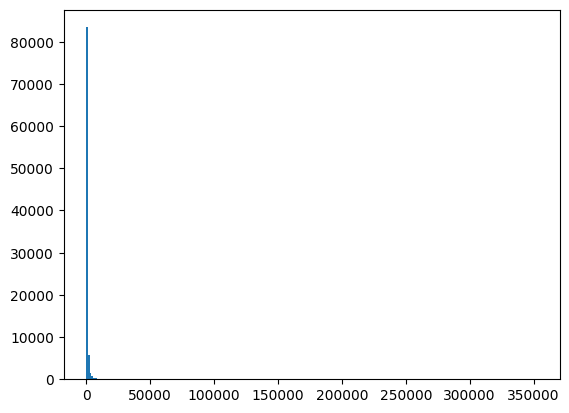

In [7]:
plt.hist(scrobbles_data['scrobbles'], bins = 256)
plt.show()

Можно заметить очень сильный разброс данных с 75% до максимума. По гистограмме видно распределение scrobbles. Чаще всего в задачах рекомендационных систем распределение имеет именно такой вид. Это обуславливается тем, что в среднем люди слушают музыку не так много, но есть люди, которые слушают музыку (особенно любимого исполнителя) очень много и из-за этого становятся некими выбросами в выборке.

Также в наших данных содержатся фиты исполнителей. Причем разделители у них разные. Что делать с такими данными? Искать всевозможные разделители в большом объеме данных долго (даже в случае чего вдруг фит обозначается символом & и по идее с помощью регулярных выражений можно было бы достать обоих (или больше) исполнителей, но что если у нас есть группа, название которой имеет ту же схему "кто-то & кто-то", как разграничивать эти ситуации?). И даже если мы разделим их, то что потом делать с значением scrobbles? Прибавлять к каждому артисту или прибавлять половину от него? Также есть будто недописанные артисты. Например: britney и britney spears. Как понять, это один и тот же артист или разные? Скорее всего данные вопросы решаются data analyst. А если нет, то я считаю, что необходимо посоветоваться с командой и решить что будет правильнее/выгоднее

In [8]:
# Объединим обе таблицы
join_data = scrobbles_data.join(artist_data, how ='left', on='artist_id')
join_data.head()

,user_id,artist_id,scrobbles,artist_name
0,1,4562,13883,Duran Duran
1,1,10191,11690,Morcheeba
2,1,494,11351,Air
3,1,6673,10300,Hooverphonic
4,1,8402,8983,Kylie Minogue


In [9]:
# На всякий случай проверяем правильно ли все соединилось
artist_data.loc[[4562,10191,494,6673,8402]]

,artist_name
artist_id,
4562,Duran Duran
10191,Morcheeba
494,Air
6673,Hooverphonic
8402,Kylie Minogue


In [10]:
# Создадим "кросс-таблицу", где столбцы это id пользователей, а
# строчки - музыкальные исполнители. На пересечении будет стоять
# значение scrobbles
cross_tab = join_data.pivot_table(index = 'artist_name', columns = 'user_id', values = 'scrobbles', aggfunc='sum')
cross_tab.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892
artist_name,,,,,,,,,,,,,,,,,,,,,
!!!,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
!Deladap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
!Distain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
#####,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
#2 Orchestra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# На всякий случай перепроверяем показания первых пяти строчек 
# прошлой таблицы
cross_tab.loc[['Duran Duran','Morcheeba','Air','Hooverphonic','Kylie Minogue']]

user_id,1,2,3,4,5,6,7,8,9,10,...,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892
artist_name,,,,,,,,,,,,,,,,,,,,,
Duran Duran,13883.0,NaN,228.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Morcheeba,11690.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Air,11351.0,NaN,686.0,181.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hooverphonic,10300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kylie Minogue,8983.0,NaN,NaN,NaN,NaN,3151.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Также проверим ненулевые значения
print('Ненулевых значений в новой таблице:', cross_tab.shape[0]*cross_tab.shape[1]-cross_tab.isnull().sum().sum())
print('Не хватает', scrobbles_data.shape[0]-(cross_tab.shape[0]*cross_tab.shape[1]-cross_tab.isnull().sum().sum()), 'записей')

Ненулевых значений в новой таблице: 92723
Не хватает 69 записей


Нехватка записей обусловлена тем, что существуют строчки в датафрейме scrobbles_data, которые полностью повторяются, но значения scrobbles у них разные. При создании кросс-таблицы они складываются, поэтому значений меньше. Проверять точно ли таких записей 69 - это очень долгий процесс (я придумала только двойным циклом сверять каждую строчку с остальными), поэтому как ОПТИМАЛЬНО проверить, что всего таких значений 69 я придумать не смогла

In [13]:
# Для применения функции близости необходимо вычесть среднее  
normalise_data = cross_tab.subtract(cross_tab.mean(axis=1), axis = 0) 
normalise_data.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892
artist_name,,,,,,,,,,,,,,,,,,,,,
!!!,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
!Deladap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
!Distain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
#####,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
#2 Orchestra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Скачивание данных
normalise_data.to_csv('/content/normalise_data.csv')

In [15]:
# Cчитывание данных на случай нехватки памяти
#normalise_data = pd.read_csv('/content/normalise_data.csv',sep =',',index_col = 0)
#normalise_data.head()

,1,2,3,4,5,6,7,8,9,10,...,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892
artist_name,,,,,,,,,,,,,,,,,,,,,
!!!,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
!Deladap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
!Distain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
#####,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
#2 Orchestra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Подсчет корреляции Пирсона
pearson_corr_data = normalise_data.T.corr() 
pearson_corr_data.head()

artist_name,!!!,!Deladap,!Distain,#####,#2 Orchestra,$Lick,$Lick Feat. Six-Fo,(1962-1966),(Hed) Planet Earth,(Pre) Kingdom,...,티아라,현아,Ｂｏｏｇｉｅｍａｎ,Ｂｏｒｎ,ＬｕＬｕ,ＭＡＮＮＥＱＵＩＮ,Ｍａｃｈｉｎｅ,ＰＥＲＥＳＴＲＯＩＫＡ,ＲＥＤ,ＶａｎｅｓｓＡ
artist_name,,,,,,,,,,,,,,,,,,,,,
!!!,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
!Deladap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
!Distain,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
#####,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
#2 Orchestra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# Проверка размерности 
pearson_corr_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17492 entries, !!! to ＶａｎｅｓｓＡ
Columns: 17492 entries, !!! to ＶａｎｅｓｓＡ
dtypes: float64(17492)
memory usage: 2.3+ GB


In [18]:
# Сохранение в отдельный файл
pearson_corr_data.to_csv('/content/pearson_corr_data.csv')

In [19]:
# Считываение из файла
#pearson_corr_data = pd.read_csv('/content/pearson_corr_data.csv', sep=',',index_col = 0)
#pearson_corr_data.info()

In [20]:
# Дальнейший код представлен для Rosetta
# "Вытаскиваем" наобходимые нам коэффициенты близости корреляции Пирсона и сортируем 
pearson_similar_artists = pearson_corr_data[['Rosetta']].rename(columns={'Rosetta':'similarity'}).sort_values('similarity', ascending=False)
pearson_similar_artists.head()

artist_name,similarity
artist_name,
This Will Destroy You,1.0
Envy,1.0
Amenra,1.0
Lantlos,1.0
Suffocate For Fuck Sake,1.0


In [21]:
# Получение схожих артистов
pearson_artists = pearson_similar_artists.index.tolist()
pearson_artists.remove('Rosetta')
print('My Pearson recommends:', pearson_artists[:4])

My Pearson recommends: ['This Will Destroy You', 'Envy', 'Amenra', 'Lantlos']


In [22]:
#  Подсчет косинусной меры близости
cosine_data = pd.DataFrame(cosine_similarity(normalise_data.fillna(0)), index= normalise_data.index,columns = normalise_data.index)
cosine_data.head()

artist_name,!!!,!Deladap,!Distain,#####,#2 Orchestra,$Lick,$Lick Feat. Six-Fo,(1962-1966),(Hed) Planet Earth,(Pre) Kingdom,...,티아라,현아,Ｂｏｏｇｉｅｍａｎ,Ｂｏｒｎ,ＬｕＬｕ,ＭＡＮＮＥＱＵＩＮ,Ｍａｃｈｉｎｅ,ＰＥＲＥＳＴＲＯＩＫＡ,ＲＥＤ,ＶａｎｅｓｓＡ
artist_name,,,,,,,,,,,,,,,,,,,,,
!!!,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
!Deladap,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
!Distain,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#####,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#2 Orchestra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# Сохранение в отдельный файл
cosine_data.to_csv('/content/cosine_data.csv')

In [24]:
# Считываение из файла
#cosine_data = pd.read_csv('/content/cosine_data.csv', sep=',',index_col = 0)
#cosine_data.info()

In [25]:
# Считаем наобходимые нам коэффициенты косинусной близости и сортируем
cosine_similar_artists = cosine_data['Rosetta'].sort_values(ascending=False)
cosine_similar_artists.head()

artist_name
Rosetta               1.000000
Nvblado               0.659807
Amenra                0.634285
Heaven In Her Arms    0.634285
Dancing Ghosts        0.540317
Name: Rosetta, dtype: float64

In [26]:
# Получение схожих артистов
cosine_artists = cosine_similar_artists.index.tolist()
cosine_artists.remove('Rosetta')
print('My cosine recommends:', cosine_artists[:5])

My cosine recommends: ['Nvblado', 'Amenra', 'Heaven In Her Arms', 'Dancing Ghosts', 'Twilight']


In [27]:
# Попробуем использовать ближайших соседей с косинусной метрикой расстояния 
# По факту это просто вторая реализация того же алгоритма
knn_cosine = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=5, n_jobs=-1)
knn_cosine.fit(normalise_data.fillna(0).values)
distances_cosine, indices_cosine = knn_cosine.kneighbors(normalise_data.fillna(0).values, n_neighbors=5)

In [28]:
index_artist = normalise_data.index.tolist().index('Rosetta')
similar_artists = indices_cosine[index_artist].tolist()
similar_artists.remove(index_artist)
print('KNN cosine recommends:', normalise_data.iloc[similar_artists].index.tolist())

KNN cosine recommends: ['Nvblado', 'Amenra', 'Heaven In Her Arms', 'Dancing Ghosts']


С метриками расстояний knn можно поиграться, но поскольку в литературе в основном говорится о корреляции Пирсона и косинусной мере близости, я решила оставить только их. При metric='correlation' расстояния и индексы ближайших соседей считались значительно дольше

In [29]:
# Попробуем использовать ближайших соседей с корреляцией 
knn_pearson = NearestNeighbors(metric='correlation', algorithm='brute', n_neighbors=5, n_jobs=-1)
knn_pearson.fit(normalise_data.fillna(0).values)
distances_pearson, indices_pearson = knn_pearson.kneighbors(normalise_data.fillna(0).values, n_neighbors=5)

In [30]:
index_artist = normalise_data.index.tolist().index('Rosetta')
similar_artists = indices_pearson[index_artist].tolist()
similar_artists.remove(index_artist)
print('KNN Pearson recommends:', normalise_data.iloc[similar_artists].index.tolist())

KNN Pearson recommends: ['Nvblado', 'Heaven In Her Arms', 'Amenra', 'Twilight']


In [31]:
# Сохраняем индексы ближайших соседей
indices_pearson = pd.DataFrame(indices_pearson, index= normalise_data.index, columns = range(0,5))
indices_pearson.to_csv('/content/indices_pearson.csv')

In [32]:
# Сохраняем индексы ближайших соседей
indices_cosine = pd.DataFrame(indices_cosine, index= normalise_data.index, columns = range(0,5))
indices_cosine.to_csv('/content/indices_cosine.csv')

В ходе выполнения данной работы у меня возникло несколько вопросов. Например, можно ли в начале выделить людей, которые слушали конкретного артиста и только потом вычислять значение функции близости? Все примеры, которые я искала считали её только для полной матрицы. 

Также мне интересно как можно проверить качество полученных результатов. Если брать именно данную реализацию, я пришла к выводу, что можно провести A/B тестирование.
Была идея разбить данные на train и test выборку и предсказывать именно рейтинги от пользователей артистам (но почему-то мне кажется, что это отходит от темы задания), там уже можно взять метрики, применимые в регрессии.

Также была идея попробовать решить данное задание с помощью матричных разложений, но погуглив об этом побольше я пришла к выводу, что это не сделать без копирования чужого git, что запрещено в решении задания. Думаю, латентной связью был бы жанр.

Далее идет больше "творческий" блок, где я пыталась придумать что-то, но в итоговой версии (файл .py) это было изменено 

In [33]:
# Пора записать универсальную функцию
def predict_artist(artist: str):
    pearson_similar_artists = pearson_corr_data[[artist]].rename(columns={artist: 'similarity'}).sort_values(
        'similarity', ascending=False).index.tolist()[:5]
    pearson_similar_artists.remove(artist)
    print('My Pearson recommends:', pearson_similar_artists[:4])
    cosine_similar_artists = cosine_data[artist].sort_values(ascending=False).index.tolist()[:5]
    cosine_similar_artists.remove(artist)
    print('My cosine recommends:', cosine_similar_artists[:5])
    index_artist = normalise_data.index.tolist().index(artist)
    similar_artists_cosine = indices_cosine.loc[index_artist].tolist()
    similar_artists_cosine.remove(index_artist)
    print('KNN cosine recommends:', normalise_data.iloc[similar_artists_cosine].index.tolist())
    similar_artists_pearson = indices_pearson.loc[index_artist].tolist()
    similar_artists_pearson.remove(index_artist)
    print('KNN Pearson recommends:', normalise_data.iloc[similar_artists_pearson].index.tolist())

In [34]:
# Тут я попробовала привести названия артистов и ввод 
# к одному виду, но если удалять пунктуационные символы
# например чтобы можно было писать AC/DC, acdc, ACDC, ac/dc
# то такие группы как "!!!" будет невозможно считать
# поэтому я только привожу в нижний регистр и убираю лишние пробелы

def prepare_text(text):
  text = re.sub('[A-Z]+', lambda m: m.group(0).lower(), text)
  text = re.sub(r"\s+$","",text)
  return text

In [35]:
prepare_artists = []
for text in (normalise_data.index.tolist()):
  prepare_artists.append(prepare_text(text))
len(prepare_artists)

17492